# Cell shape analysis

## Setup

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

import geomstats.backend as gs

INFO: Using numpy backend


## Generation of simple discrete curves

In [3]:
# Return a discrete closed curve (array of 2D points) representing a square
# in counter-clockwise order
def unit_square(nb_points_side):
    nb_points = 2*(nb_points_side) + 2*(nb_points_side - 2)
    square = gs.zeros((nb_points, 2))
    
    pos_axis = gs.linspace(-1, 1, nb_points_side)
    neg_axis = gs.flip(pos_axis)
    ones = gs.ones(nb_points_side)
    minus_ones = -ones
    
    square[:nb_points_side] = gs.vstack((pos_axis, minus_ones)).T
    square[nb_points_side - 1 : 2*nb_points_side - 1] = gs.vstack((ones, pos_axis)).T
    square[2*nb_points_side - 2 : 3*nb_points_side - 2] = gs.vstack((neg_axis, ones)).T
    square[3*nb_points_side - 3 : 4*nb_points_side - 4] = gs.vstack((minus_ones, neg_axis)).T[:nb_points_side - 1]
    
    return square

# Return a discrete closed curve (array of 2D points) representing an ellipse of equation x²/a² + y²/b² = 1
# in counter-clockwise order
def unit_ellipse(nb_points, a, b):
    t = gs.linspace(0, 2*gs.pi, nb_points + 1)[: -1]
    x = a*gs.cos(t)
    y = b*gs.sin(t)
    ellipse = gs.vstack((x, y)).T
    
    return ellipse


# Return a discrete closed curve (array of 2D points) representing a circle
# in counter-clockwise order
def unit_circle(nb_points_half):
    return unit_ellipse(nb_points_half, 1, 1)

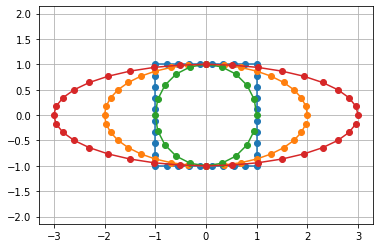

In [4]:
# Plot a discrete curve (array of 2D points)
def plot_curve(curve):
    plt.plot(curve[:, 0], curve[:, 1], '-o')
    
plot_curve(unit_square(10))
plot_curve(unit_ellipse(36, 2, 1))
plot_curve(unit_circle(20))
plot_curve(unit_ellipse(36, 3, 1))
plt.axis('equal')
plt.grid()

## Geodesics between simple curves

In [5]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

square = unit_square(11)
circle = unit_circle(40)

geodesic = metric.geodesic(initial_curve=square, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

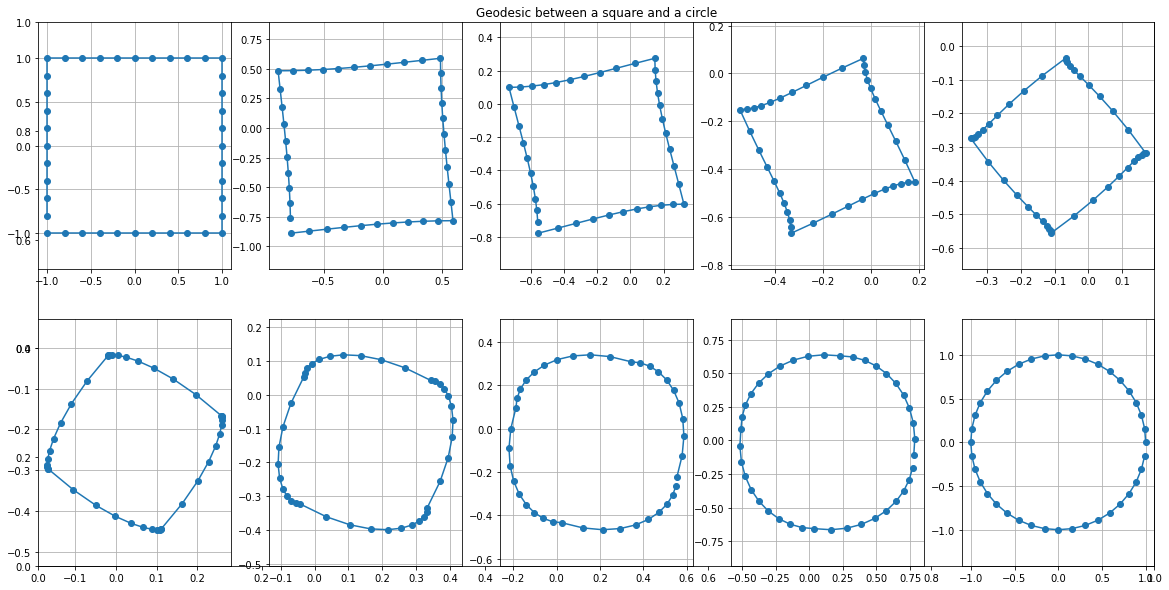

In [6]:
fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a square and a circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    plot_curve(points[i])
    plt.axis('equal')
    plt.grid()

The geodesic distance takes the initial points of the curves into account, which is why the bottom-left vertex of the square tries to match the rightmost point of the circle.

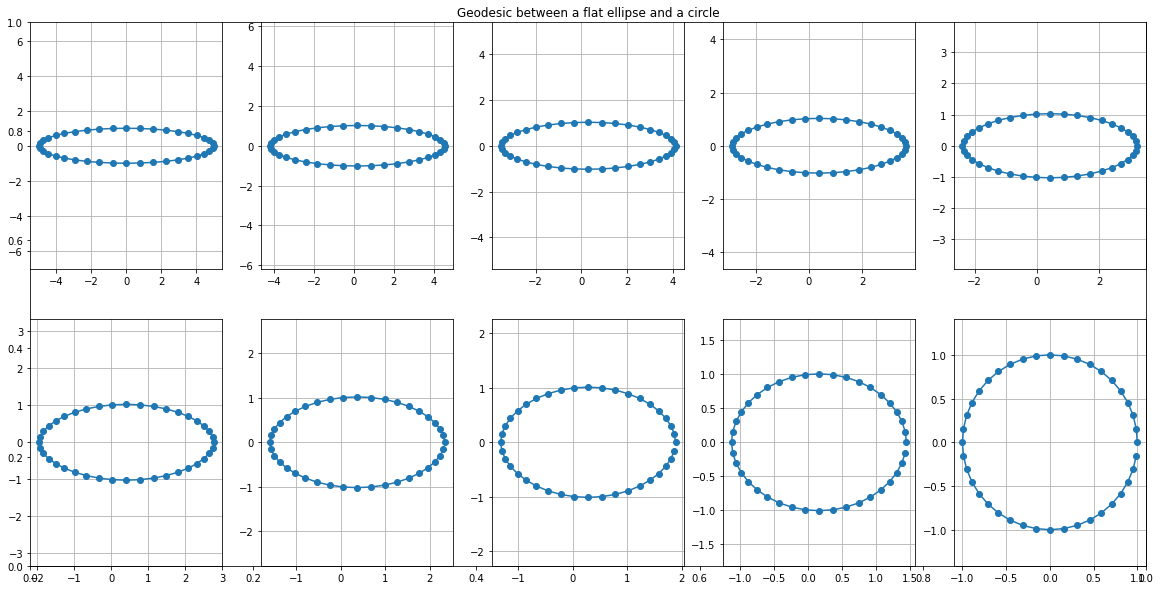

In [7]:
flat_ellipse = unit_ellipse(40, 5, 1)
circle = unit_circle(40)

geodesic = metric.geodesic(initial_curve=flat_ellipse, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a flat ellipse and a circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    plot_curve(points[i])
    plt.axis('equal')
    plt.grid()

The initial points are the same, which is why there is no rotation.

## Geodesics between perturbations of simple curves

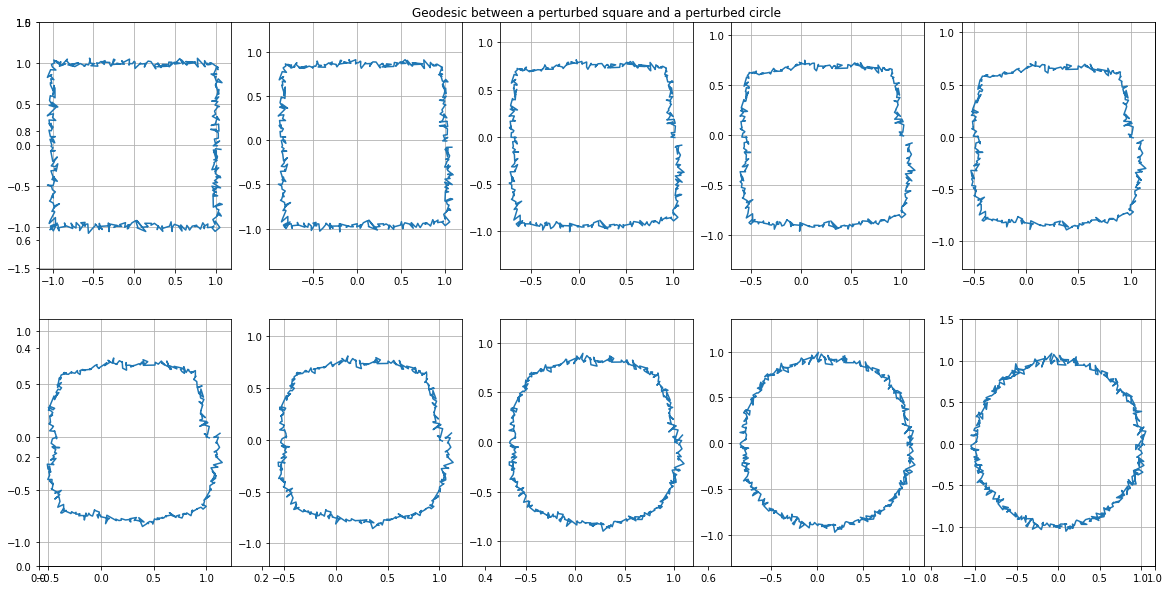

In [8]:
sigma = 0.03
gs.random.seed(1234)

square = list(unit_square(101))
square = [square[(i + 150)%len(square)] for i in range(len(square))]
square = gs.array(square)
circle = unit_circle(400)

gaussian_noise_1 = gs.vstack((gs.random.normal(0, sigma, 400), gs.random.normal(0, sigma, 400))).T
gaussian_noise_2 = gs.vstack((gs.random.normal(0, sigma, 400), gs.random.normal(0, sigma, 400))).T

perturbed_square = square + gaussian_noise_1
perturbed_circle = circle + gaussian_noise_2

geodesic = metric.geodesic(initial_curve=perturbed_square, end_curve=perturbed_circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a perturbed square and a perturbed circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    curve = points[i]
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.grid()

Even if the endpoints of the initial and final curves are very close to each other, they get split up a little along the geodesic.

## Load the data

In [9]:
import geomstats.datasets.utils as data_utils

cells, cell_lines, treatments = data_utils.load_cells()
print(len(cells), len(cell_lines), len(treatments))

367 367 367


We need discrete curves with the same number of sampled points in order to compute distances between them, which is why the following interpolation is needed.

In [10]:
#Interpolate a discrete curve with nb_point from a discrete curve
def interpolate(curve, nb_points):
    old_length = curve.shape[0]
    res = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        res[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return res

nb_sampling = 100

for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

(274.5180000000001, 417.1219999999987, -402.8, -297.2)

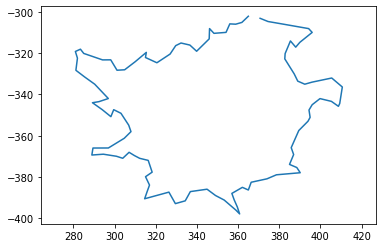

In [11]:
i = gs.random.randint(len(cells))
cell = cells[i]

plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')

## Pre-process the data

In order to quotient out scaling and rotation, we use functions initially designed to center, rescale and align sets of landmarks.

In [12]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]
cells_shape = preshape.align(point=cells_preshape, base_point=base_curve)

(-0.11994607909936134,
 0.1387211851459011,
 -0.12384715592073912,
 0.1652384479750068)

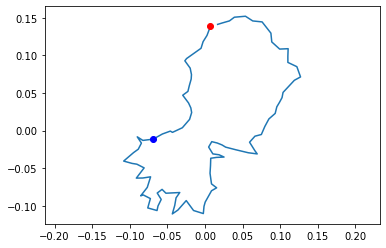

In [13]:
i = gs.random.randint(len(cells_shape))
cell = cells_shape[i]

plt.plot(cell[:, 0], cell[:, 1])
plt.plot(cell[0, 0], cell[0, 1], 'ro')
plt.plot(cell[nb_sampling//5, 0], cell[nb_sampling//5, 1], 'bo')
plt.axis('equal')

## Data analysis

By computing L² distances between the square root velocities of the curves (note that it quotients out translations), we can compute the distance matrix now that we reduced the effect of rotation and scaling. I did not use the dist function from geomstats because it would have computed the same square root velocities too much times and because it takes the initial points of the curves into account.

In [14]:
N = len(cells_shape)
srvs = [metric.square_root_velocity(cell) for cell in cells_shape]
dist_matrix = gs.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        dist_matrix[i, j] = dist_matrix[j, i] = metric.l2_metric(nb_sampling - 1).dist(srvs[i], srvs[j])

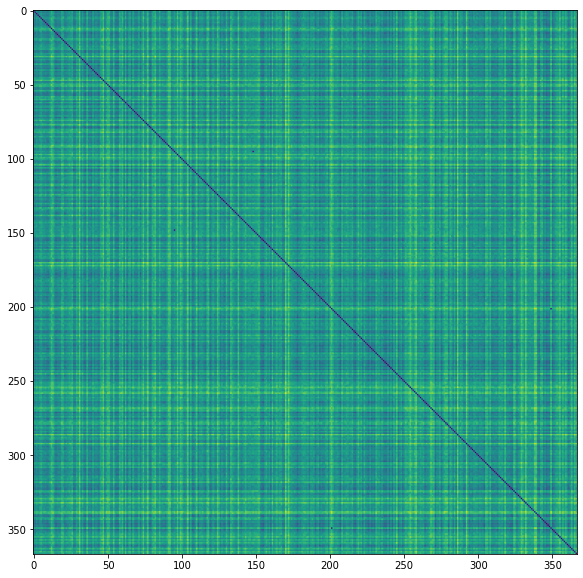

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(dist_matrix)

We can then perform clustering on the dataset with the goal of recovering the true labels.

### Treatments on DUNN cells

Number of jasp (first class) : 95
Number of cytd (second class) : 93


Text(0.5, 1.0, 'Dunn cells')

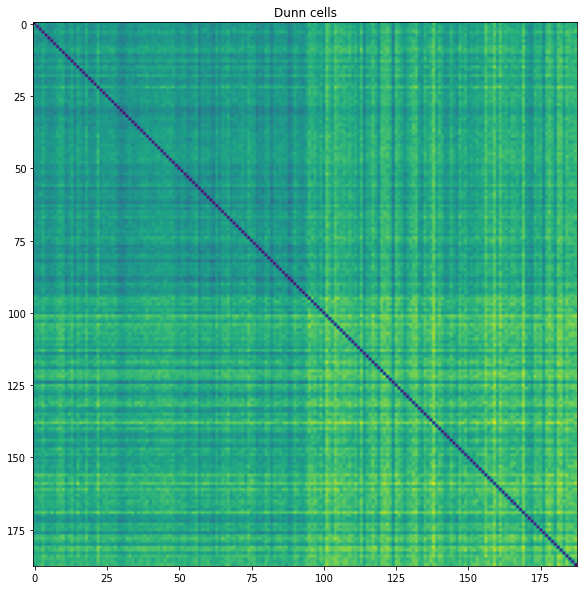

In [16]:
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]
print("Number of jasp (first class) :", len(dunn_jasp_indexes))
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
print("Number of cytd (second class) :", len(dunn_cytd_indexes))

dunn_indexes = gs.concatenate((dunn_jasp_indexes, dunn_cytd_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(dunn_matrix)
plt.title("Dunn cells")

In [17]:
from geomstats.learning.agglomerative_hierarchical_clustering import AgglomerativeHierarchicalClustering

clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 2, distance='precomputed')
clustering2.fit(dunn_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


We can see a vague pattern on the matrix but the agglomerative clustering couldn't identify the labels. Unfortunately, the only point belonging to class 1 is not necessarily an outlier, the same thing happens with higher values for n_clusters and for other linking policies.

For other comparisons, the scenario is pretty much the same.

### Treatments on DLM8 cells

Number of jasp (first class) : 62
Number of cytd (second class) : 82
Number of noco (third class) : 35


Text(0.5, 1.0, 'DLM8 cells')

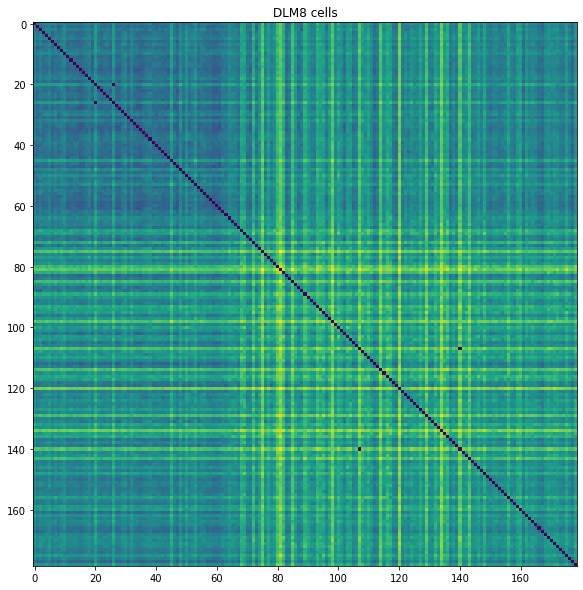

In [18]:
dlm8_jasp_indexes = gs.where((cell_lines == "dlm8") & (treatments == "jasp"))[0]
print("Number of jasp (first class) :", len(dlm8_jasp_indexes))
dlm8_cytd_indexes = gs.where((cell_lines == "dlm8") & (treatments == "cytd"))[0]
print("Number of cytd (second class) :", len(dlm8_cytd_indexes))
dlm8_noco_indexes = gs.where((cell_lines == "dlm8") & (treatments == "noco"))[0]
print("Number of noco (third class) :", len(dlm8_noco_indexes))

dlm8_indexes = gs.concatenate((dlm8_jasp_indexes, dlm8_cytd_indexes, dlm8_noco_indexes))
dlm8_matrix = dist_matrix[dlm8_indexes][:, dlm8_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(dlm8_matrix)
plt.title("DLM8 cells")

In [19]:
clustering3 = AgglomerativeHierarchicalClustering(n_clusters = 5, distance='precomputed')
clustering3.fit(dlm8_matrix)
print(clustering3.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Cell lines treated with jasp

Number of dunn (first class) : 95
Number of dlm8 (second class) : 62


Text(0.5, 1.0, 'jasp treatment')

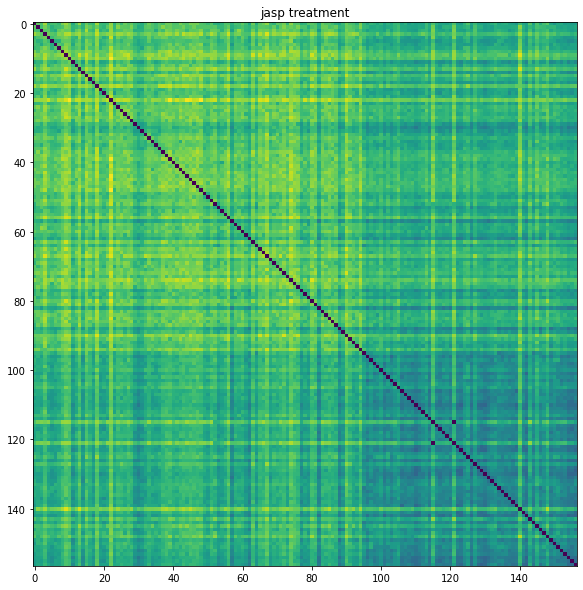

In [20]:
print("Number of dunn (first class) :", len(dunn_jasp_indexes))
print("Number of dlm8 (second class) :", len(dlm8_jasp_indexes))

jasp_indexes = gs.concatenate((dunn_jasp_indexes, dlm8_jasp_indexes))
jasp_matrix = dist_matrix[jasp_indexes][:, jasp_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(jasp_matrix)
plt.title("jasp treatment")

In [21]:
clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 2, distance='precomputed')
clustering2.fit(jasp_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Cell lines treated with cytd

Number of dunn (first class) : 93
Number of dlm8 (second class) : 82


Text(0.5, 1.0, 'cytd treatment')

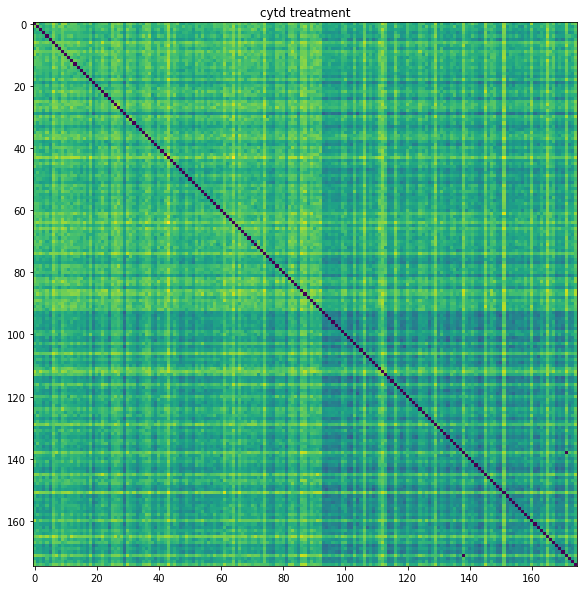

In [22]:
print("Number of dunn (first class) :", len(dunn_cytd_indexes))
print("Number of dlm8 (second class) :", len(dlm8_cytd_indexes))

cytd_indexes = gs.concatenate((dunn_cytd_indexes, dlm8_cytd_indexes))
cytd_matrix = dist_matrix[cytd_indexes][:, cytd_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(cytd_matrix)
plt.title("cytd treatment")

In [23]:
clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 2, distance='precomputed')
clustering2.fit(cytd_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
